<a href="https://colab.research.google.com/github/jay-mini/hello-world/blob/master/Diffusion1_PINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pyDOE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18184 sha256=74bc53a84dd3076b3c58aad03c0927eed5bc601cef09ab9e23e7644d67ac58c3
  Stored in directory: /root/.cache/pip/wheels/83/ce/8a/87b25c685bfeca1872d13b8dc101e087a9c6e3fb5ebb47022a
Successfully built pyDOE


In [ ]:
import numpy as np
import torch
import pandas as pd
from pyDOE import lhs
from collections import OrderedDict
import matplotlib.pyplot as plt
import scipy.io
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable

#设置随机种子
np.random.seed(1234)

#设置计算用的设备
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

#定义神经网络,用于拟合微分方程的解
class DNN(torch.nn.Module):
    def __init__(self,layers):
        #layers 为各层网络的输入和输出维度
        #对于n层隐藏层的神经网络,layers的维度应该为n+1
        super(DNN, self).__init__()
        #初始化

        self.depth = len(layers)-1# 存储的为各层
        self.activation = torch.nn.Tanh

        layer_list = list()

        for i in range(self.depth - 1):
            #输出层额外定义
            layer_list.append(
                ('layer_%d' % i,torch.nn.Linear(layers[i],layers[i+1]))
            )
            layer_list.append(
                ('activation_%d' % i,self.activation())
            )
        #单独添加输出层
        layer_list.append(
            ('layer_%d' % (self.depth-1),torch.nn.Linear(layers[-2],layers[-1]))
        )

        #记住网络各层的添加顺序
        layerDict = OrderedDict(layer_list)
        #按照顺序定义成DNN
        self.layers = torch.nn.Sequential(layerDict)

    #设置前推
    def forward(self,x):
        out = self.layers(x)
        return out

#定义PINN类
class PINN():
    def __init__(self,X_u,u,X_f,lb,ub,layers):
        '''
        :param X_u: 已知数据的自变量输入
        :param u: 已知数据因变量输入
        :param X_f: 求解区域内部自变量的输入
        :param lb: 左边界
        :param ub: 右边界
        :param layers: 神经网络各层输入和输出维度
        '''

        self.plot_iter = list()
        self.plot_loss = list()

        #边界
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)

        #数据
        self.x_u = torch.tensor(X_u[:,0:1],requires_grad=True).float().to(device)
        self.t_u = torch.tensor(X_u[:,1:],requires_grad=True).float().to(device)
        self.x_f = torch.tensor(X_f[:,0:1],requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f[:,1:],requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)

        self.layers = layers

        #神经网络
        self.dnn = DNN(layers).to(device)

        #优化器
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(),
            lr=1.0,
            max_iter=50000,
            max_eval=50000,
            history_size=50,
            tolerance_grad=1e-5,
            tolerance_change=1.0 * np.finfo(float).eps,
            # tolerance_change = 1e-6,
            line_search_fn="strong_wolfe"
        )

        # self.optimizer = torch.optim.Adam(
        #     self.dnn.parameters(),
        #     lr = 0.001,
        #     betas=(0.9,0.99),
        #     eps=1e-8,
        #     weight_decay= 0.0001
        # )

        self.iter = 0

    def net_u(self,x,t):
        #预测u的值
        u = self.dnn(torch.cat([x,t],dim=1))
        return u

    def net_f(self,x,t):
        #预测 f
        u = self.net_u(x,t)

        u_t = torch.autograd.grad(
            u,t,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]

        u_x = torch.autograd.grad(
            u,x,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]

        u_xx = torch.autograd.grad(
            u_x,x,
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]

        f = u_t - u_xx + torch.exp(-t)*(torch.sin(np.pi * x)-np.pi ** 2 * torch.sin(np.pi * x))

        return f

    def loss_func(self):
        self.optimizer.zero_grad()

        u_pred = self.net_u(self.x_u,self.t_u)
        f_pred = self.net_f(self.x_f,self.t_f)

        loss_u = torch.mean((self.u - u_pred) ** 2)
        loss_f = torch.mean(f_pred ** 2)

        loss = loss_u + loss_f
        self.plot_loss.append(loss.detach().cpu().numpy())

        loss.backward()

        self.iter += 1
        self.plot_iter.append(self.iter)
        if self.iter % 100 == 0:
            print(
                'Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e'
                %(self.iter,loss,loss_u,loss_f)
            )
        return loss

    def train(self):
        self.dnn.train()
        # for i in range(self.iterations):
        self.optimizer.step(self.loss_func)

    def predict(self,X):
        x = torch.tensor(X[:,0:1],requires_grad=True).float().to(device)
        t = torch.tensor(X[:,1:],requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(x,t)
        f = self.net_f(x,t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()

        return u,f

    def plot(self):
        plt.figure(1)
        plt.plot(self.plot_iter, self.plot_loss, color="r", label="Loss")
        plt.xlabel("iter")
        plt.ylabel("loss")
        plt.ylim(0,0.1)
        plt.legend()
        plt.show()
    def liter(self):
      return self.plot_iter


Iter 100, Loss: 5.52146e-03, Loss_u: 1.16474e-03, Loss_f: 4.35673e-03
Iter 200, Loss: 1.54097e-03, Loss_u: 6.57166e-04, Loss_f: 8.83809e-04
Iter 300, Loss: 5.12846e-04, Loss_u: 1.22772e-04, Loss_f: 3.90073e-04
Iter 400, Loss: 1.73333e-04, Loss_u: 7.35106e-06, Loss_f: 1.65982e-04
Iter 500, Loss: 6.84674e-05, Loss_u: 4.78472e-06, Loss_f: 6.36826e-05
Iter 600, Loss: 3.49965e-05, Loss_u: 2.24171e-06, Loss_f: 3.27548e-05
Iter 700, Loss: 2.21054e-05, Loss_u: 1.86840e-06, Loss_f: 2.02370e-05
Iter 800, Loss: 1.09992e-05, Loss_u: 2.57908e-06, Loss_f: 8.42009e-06
Iter 900, Loss: 8.78787e-06, Loss_u: 2.23065e-06, Loss_f: 6.55722e-06
Iter 1000, Loss: 6.93395e-06, Loss_u: 1.82515e-06, Loss_f: 5.10881e-06
Iter 1100, Loss: 5.63675e-06, Loss_u: 1.41551e-06, Loss_f: 4.22124e-06
Iter 1200, Loss: 4.76043e-06, Loss_u: 1.11557e-06, Loss_f: 3.64486e-06
Iter 1300, Loss: 4.07750e-06, Loss_u: 8.23465e-07, Loss_f: 3.25404e-06
Iter 1400, Loss: 3.23439e-06, Loss_u: 7.12414e-07, Loss_f: 2.52198e-06
Iter 1500, Loss

Error u: 7.815236e-04
最终训练次数:2142


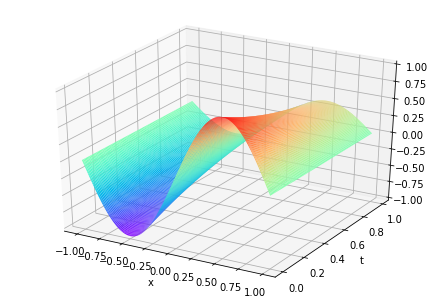

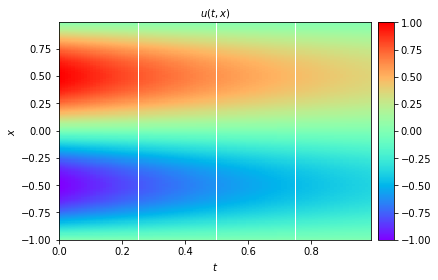

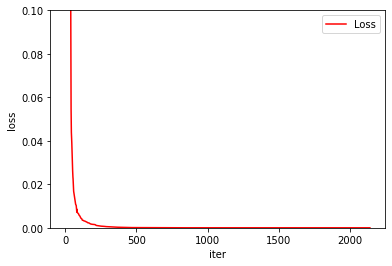

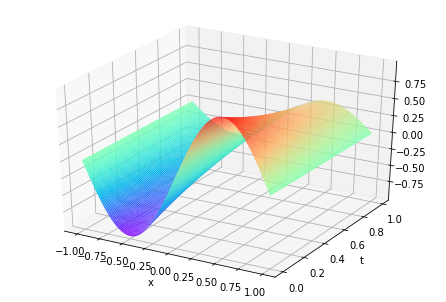

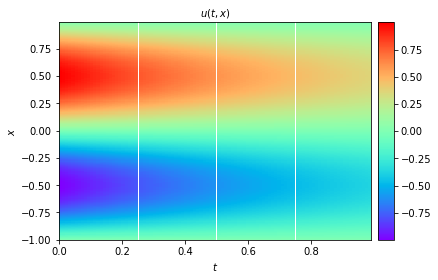

In [ ]:
for i in range(1):
  #例子设置
  N_u = 70
  N_f = 10000
  layers = [2,32,32,32,1]
  data = pd.read_table(r'/content/Data/train.dat', sep=' ')

  x_u_train = np.array(data.loc[:,['x']]).flatten()[:,None]
  t_u_train = np.array(data.loc[:,['t']]).flatten()[:,None]
  u_trian = np.array(data.loc[:,['y']])

  X_u_train = np.hstack((x_u_train[:,0:1],t_u_train[:,0:1]))

  lb = np.array([-1.0,0.0])
  ub = np.array([1.0,1.0])

  X_f_train = lb+(ub-lb)*lhs(2,N_f)
  # x_f_train = np.arange(-1.0,1.0,0.0002)
  # t_f_train = np.arange(0.0,1.0,0.0001)
  # X_f_train = np.vstack((x_f_train.T,t_f_train.T)).T

  model = PINN(X_u_train,u_trian,X_f_train,lb,ub,layers)

  model.train()

  dict_ = scipy.io.loadmat(r'/content/Data/data.mat')
  t = dict_['t'].flatten()[:,None]
  x = dict_['x'].flatten()[:,None]
  Exact = np.real(dict_['u'])

  X,T = np.meshgrid(x,t)

  X_star = np.hstack((X.flatten()[:,None],T.flatten()[:,None]))
  u_star = Exact.flatten()[:,None]


  fig = plt.figure(2)
  ax = Axes3D(fig)
  plt.xlabel('x')
  plt.ylabel('t')
  ax.plot_surface(X,T,Exact,rstride=1,cstride=1,cmap='rainbow')
  # #画相图
  fig4 = plt.figure()
  ax = fig4.add_subplot()

  h = ax.imshow(Exact.T,interpolation='nearest',cmap='rainbow',
                extent=[t.min(),t.max(),x.min(),x.max()],
                origin='lower',aspect='auto')
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right",size="5%",pad=0.10)
  cbar = fig4.colorbar(h,cax=cax)
  cbar.ax.tick_params(labelsize=10)
  line = np.linspace(x.min(),x.max(),2)[:,None]
  ax.plot(t[25]*np.ones((2,1)),line,'w-',linewidth=1)
  ax.plot(t[50]*np.ones((2,1)),line,'w-',linewidth=1)
  ax.plot(t[75]*np.ones((2,1)),line,'w-',linewidth=1)

  ax.set_xlabel('$t$',size = 10)
  ax.set_ylabel('$x$',size = 10)

  ax.legend(
      loc = 'upper center',
      bbox_to_anchor = (0.9,-0.05),
      ncol = 5,
      frameon = False,
      prop = {'size':15}
  )
  ax.set_title('$u(t,x)$',fontsize = 10)
  ax.tick_params(labelsize = 10)


  u_pred,f_pred = model.predict(X_star)
  error_u = np.linalg.norm((u_star-u_pred),2)/np.linalg.norm(u_star,2)
  # error_u = torch.mean((u_star-u_pred) ** 2)
  print('Error u: %e' %(error_u))
  print('最终训练次数:%d' % model.liter()[-1])
  model.plot()

  U_pred = griddata(X_star,u_pred.flatten(),(X,T),method='cubic')
  fig1 = plt.figure(3)
  ax = Axes3D(fig1)
  plt.xlabel('x')
  plt.ylabel('t')
  ax.plot_surface(X,T,U_pred,rstride=1,cstride=1,cmap='rainbow')

  #画相图
  fig2 = plt.figure()
  ax = fig2.add_subplot()

  h = ax.imshow(U_pred.T,interpolation='nearest',cmap='rainbow',
                extent=[t.min(),t.max(),x.min(),x.max()],
                origin='lower',aspect='auto')
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right",size="5%",pad=0.10)
  cbar = fig2.colorbar(h,cax=cax)
  cbar.ax.tick_params(labelsize=10)
  line = np.linspace(x.min(),x.max(),2)[:,None]
  ax.plot(t[25]*np.ones((2,1)),line,'w-',linewidth=1)
  ax.plot(t[50]*np.ones((2,1)),line,'w-',linewidth=1)
  ax.plot(t[75]*np.ones((2,1)),line,'w-',linewidth=1)

  ax.set_xlabel('$t$',size = 10)
  ax.set_ylabel('$x$',size = 10)

  ax.legend(
      loc = 'upper center',
      bbox_to_anchor = (0.9,-0.05),
      ncol = 5,
      frameon = False,
      prop = {'size':15}
  )
  ax.set_title('$u(t,x)$',fontsize = 10)
  ax.tick_params(labelsize = 10)

  plt.show()